In [1]:
include("TDCM_modelling.jl")

In [3]:
using RCall

R"""
load("TDCM_Multilevel_data_three_skills.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [4]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 12 threads


In [48]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [76]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [77]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end
# for j in 1:J
#     model.mu_beta_star[j] = data[:beta][j]
#     model.V_beta_star[j] = model.V_beta_star[j] ./ 100
# end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [78]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.01, maxiter=10, verbose=false)
    #update_categorical_variational_distribution2(model, 2, step=.01, maxiter=1, verbose=false)
    update_normal_variational_distribution(model, init_step = .006, maxiter = 3, verbose = false)
end

In [79]:
skill_profiles = Dict(1=>[0, 0], 
                 2=>[0, 1],
                 3=>[1, 0],
                 4=>[1, 1])

skill_numbers = Dict([0, 0]=>1, 
                 [0, 1]=>2,
                 [1, 0]=>3,
                 [1, 1]=>4)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [80]:
attribute_accs

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

In [81]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [82]:
attribute_accs

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

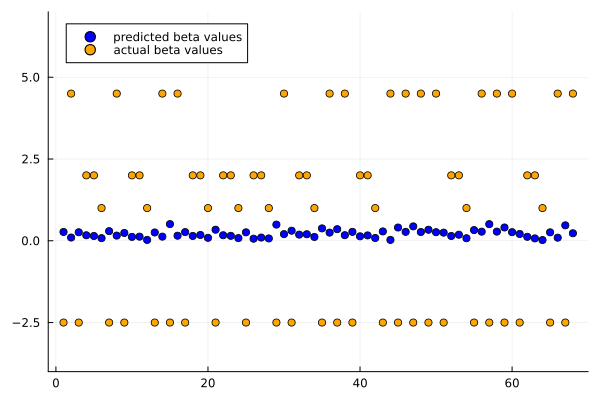

In [83]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [35]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [44]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [45]:
update_normal_variational_distribution(model, init_step = .0001, maxiter = 100, verbose = false)

In [46]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

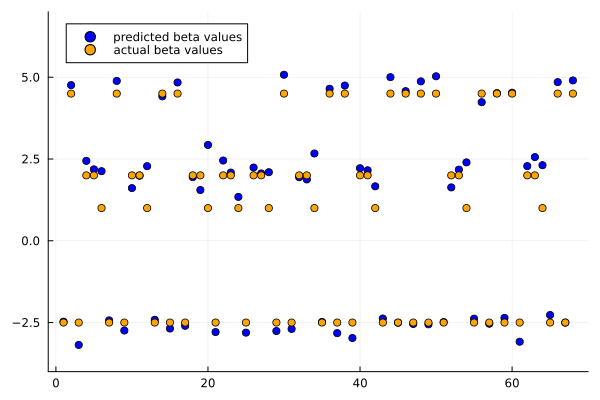

In [47]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [282]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [283]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 10
                model.b_tau_star[k][t][1][feature] = 0.01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 10
                    model.b_tau_star[k][t][z + 1][feature] = 0.01
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [286]:
update_normal_variational_distribution2(model, init_step = .01, maxiter = 500, verbose = false)

In [287]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

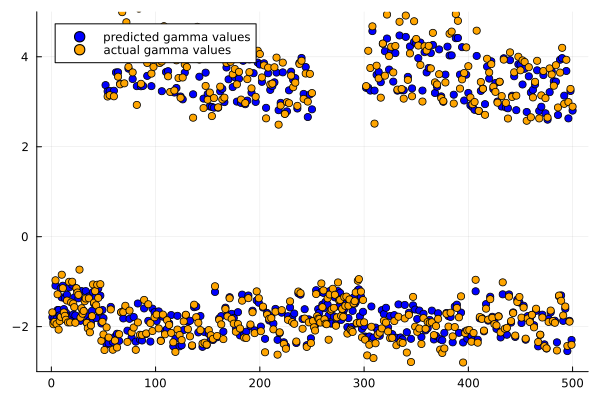

In [288]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-3, 5)

**Estimating omega with correct gamma**

In [256]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [257]:
# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [273]:
update_normal_variational_distribution3(model, init_step = .1, maxiter = 400, verbose = false)

In [274]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

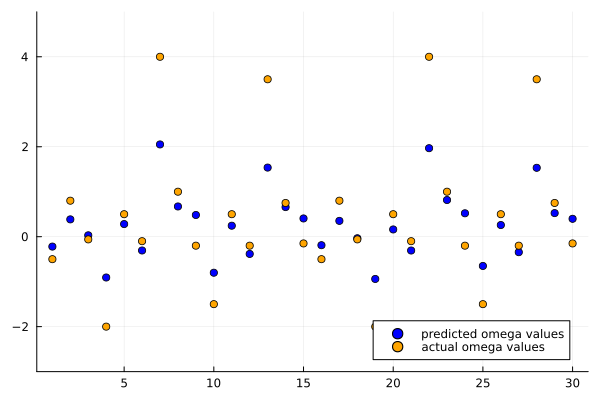

In [275]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-3, 5)

In [271]:
model.a_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[3.0]], [[3.0, 3.0], [3.0, 3.0]]]
 [[[3.0]], [[3.0, 3.0], [3.0, 3.0]]]

In [272]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

**Estimate Attribute profile, Gamma, and Omega simultaneously**

In [376]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [377]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
#     end
# end

# Fix true value of mu_beta
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                #model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    #model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# Sample Z
for i in 1:N
    sample_Z(model, i, 1)
    sample_Z(model, i, 2)
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [ ]:
for iter in 1:100
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end
    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = .1, maxiter = 30, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

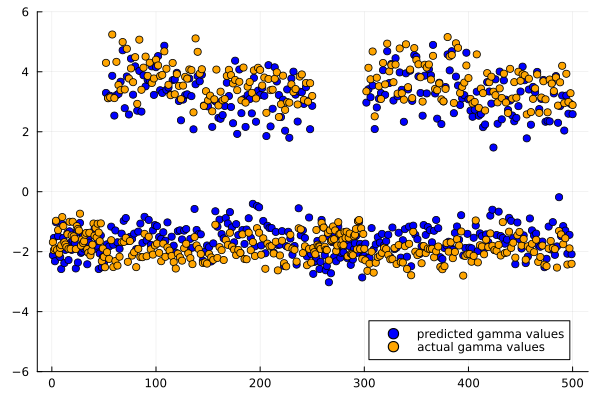

In [112]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-6, 6)

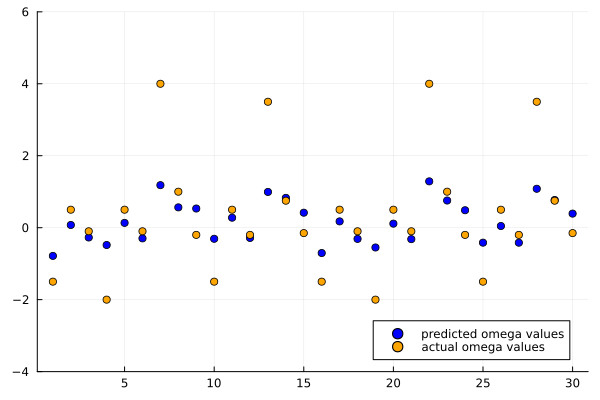

In [113]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, :, feature])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [308]:
model.V_omega_star

2-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[5.544079388983386 2.3265995249707134 -0.8288918007053369; 2.3265995249707134 5.402896631828825 -2.2108412540728026; -0.8288918007053369 -2.2108412540728026 1.0679078904977348]]], [[[2.0541221529476603 0.42006840729780265 -0.24905628583695633; 0.42006840729780265 0.5319739751844637 0.36613017312717366; -0.24905628583695633 0.36613017312717366 0.4241614340464776], [2.500665483417103 0.5666705995718333 -2.3158814224936664; 0.5666705995718333 1.5335177929686998 -0.8063148750775713; -2.3158814224936664 -0.8063148750775713 2.229188457250281]], [[2.2047788871251055 -0.2226407654515409 -0.31554293081041734; -0.2226407654515409 0.8846634259852871 -0.04809293506555829; -0.31554293081041734 -0.04809293506555829 0.08889920371034414], [0.9117840722060988 0.6274697431288729 0.37907048169019875; 0.6274697431288729 1.225984461671084 0.37602736318635577; 0.37907048169019875 0.37602736318635577 0.17432470699418912]]]]
 [[[[3.929664883322425

In [245]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

**Estimating Tau with true value of omega and gamma**

In [27]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [36]:
# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./30
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./30
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 30
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./30
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# # Initialize true values of tau
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = S/2
#                 model.b_tau_star[k][t][1][feature] = (S/2 - 1) * .04
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = S/2
#                     model.b_tau_star[k][t][z + 1][feature] = (S/2 - 1) * .04
#                 end
#             end
#         end
#     end
# end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end



In [37]:
# for iter in 1:100
#     update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 30, verbose = true)
#     for k in 1:K
#         for t in 1:O
#             num_features = length(model.gamma_sample[k][t][1][1][1])
#             if t == 1
#                 for feature in 1:num_features
#                     sample_τ(model, k, t, 0, feature)
#                 end
#             else
#                 for z in 0:1
#                     for feature in 1:num_features
#                         sample_τ(model, k, t, z, feature)
#                     end
#                 end
#             end
#         end
#     end
# end
update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 2500, verbose = true)

ELBO: -28.76310894313251
b*: 73.46274782350909
ELBO: -27.8317095331211
gradient log(b*): -38.787997645389254
ELBO: -57.8692710427161
ELBO: -59.82869850294966
b*: 72.54933822857768
ELBO: -59.57358923934806
gradient log(b*): -19.278201501755024
b*: 235.35258554378814
gradient log(b*): -73.55642902718336
b*: 264.67558715863635
ELBO: -55.243158914077995
gradient log(b*): -3.6421093176842083
ELBO: -28.34440720756931
b*: 263.2627231716264
ELBO: -57.02700674159998
b*: 233.6277673186014
gradient log(b*): -37.629934149245756
gradient log(b*): -29.69946447113154
b*: 226.11907799560768
b*: 72.40961088033208
gradient log(b*): 17.700172633312526
gradient log(b*): -32.48444690844713
ELBO: -27.99921174473729
ELBO: -60.411573964691726
b*: 264.5792069688457
gradient log(b*): -59.130530173270586
b*: 73.17835244747033
gradient log(b*): -16.9837047425265
ELBO: -56.96487607843468
b*: 232.75027959434598
gradient log(b*): -33.83814480685877
ELBO: -27.536248037593985
b*: 72.17477389828318
ELBO: -59.2765785390

Excessive output truncated after 524293 bytes.

gradient log(b*): -20.78483816346831
gradient log(b*): -13.107057069916298
gradient log(b*): -14.326132515548725
ELBO: -2.9164779653467314
gradient log(b*): -18.895355667493877
b*: 25.04780475791998
ELBO: 1.0655789114833512
gradient log(b*): -22.989414090485187
b*: 21.270150493119456
gradient log(b*): -24.872750073635583
ELBO: -0.9128525504146857
b*: 22.842788793038448
ELBO: 23.210182212992443
b*: 7.027526234886779
gradient log(b*): -17.279329614670676
gradient log(b*): -20.673369408152944
ELBO: 22.665584816014164
b*: 7.435596748143748
gradient log(b*): -19.15208317902059
ELBO: 2.3411907946086337
b*: 21.024337128712215
gradient log(b*): -26.62419706112035
ELBO: -2.62223140187439
b*: 24.990287462134944
ELBO: 1.092293317405506
gradient log(b*): -22.246853101630457
b*: 21.21731151916558
ELBO: 22.60331872090682
b*: 7.4213696596710035
ELBO: -1.0780911336579655
gradient log(b*): -20.05033965534945
b*: 22.795613832006847
gradient log(b*): -15.701370583213382
ELBO: 1.3663294730829154
b*: 20.96

In [34]:
update_inverse_gamma_distribution_va(model)

In [38]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end
mean(model.tau_sample[2][2][1][2])

0.1766766364616565

In [39]:
model.a_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [40]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.3681007816235304]], [[2.3702876907359554, 3.794422887833501], [2.4628769709861396, 2.7068913255937894]]]
 [[[2.1758986604781922]], [[2.488155736819653, 4.215812415266939], [2.281293200404011, 3.5601861029816533]]]

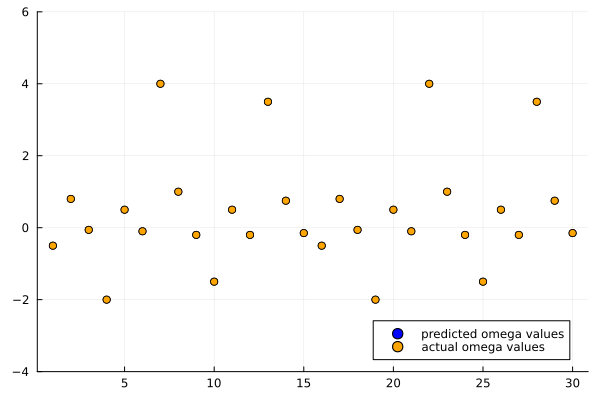

In [33]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [439]:
model.a_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [440]:
model.b_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

In [441]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(model.b_tau_prior[2][2][1][1] + 1/2 * est) / (25 + model.a_tau_prior[2][2][1][1] + 1)

0.0449975722238702

In [442]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(1/2 * est) / (25)

0.05179504733669521

In [483]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
(model.b_tau_prior[2][2][1][1] * (a - 1) + (a - 1)/2 * est) / (model.a_tau_prior[2][2][1][1] + 1 + S/2)

0.4798817361766747

In [484]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
((a - 1)/2 * est) / (S/2)

0.018958741800416245

In [457]:
rand(InverseGamma(25, 1))

0.06660945577445676

**Estimating full TDCM model**

In [19]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [20]:
# Initialize tau distribution
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.a_tau_star[k][t][1][feature] = 100.0
                model.b_tau_star[k][t][1][feature] = 1.0
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.a_tau_star[k][t][z + 1][feature] = 100.0
                    model.b_tau_star[k][t][z + 1][feature] = 1.0
                end
            end
        end
    end
end

In [21]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize random gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= 2.0
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end

# Initialize attribute profiles as no masteries
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= [0.4, 0.2, 0.2, 0.2]
#     end
# end

# Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]/5
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [ ]:
for iter in 1:100
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end

    update_normal_variational_distribution(model, init_step = .06, maxiter = 10, verbose = false)
    sample_β(model)

    update_normal_variational_distribution2(model, init_step = .03, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .05, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = 1e-5, maxiter = 1, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

In [10]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [11]:
accuracy

0.7696

In [12]:
attribute_accs

8-element Vector{Float64}:
 0.9945288753799392
 0.3754152823920266
 0.24615384615384617
 0.41496598639455784
 0.45161290322580644
 0.5087108013937283
 0.3862433862433862
 0.9919517102615694

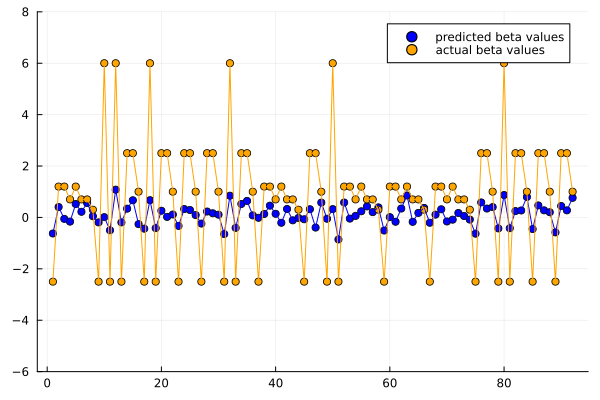

In [13]:
pred_beta_values = []
actual_beta_values = []
for j in 1:21
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 8)

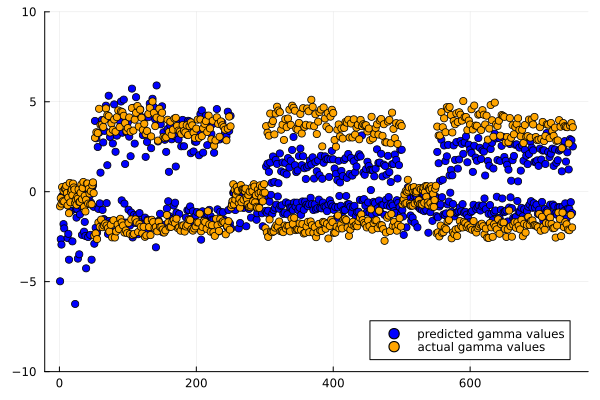

In [14]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-10, 10)

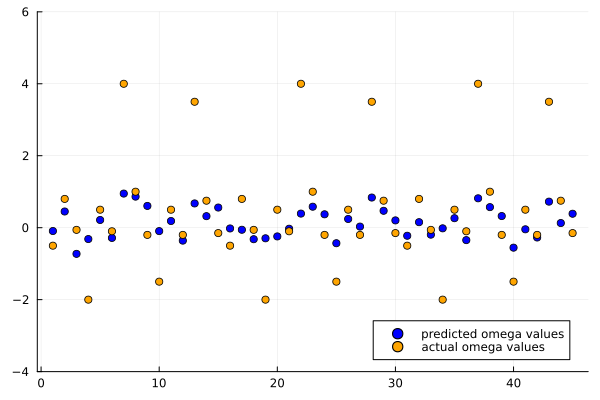

In [15]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [16]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[100.0]], [[100.0, 100.0], [100.0, 100.0]]]
 [[[100.0]], [[100.0, 100.0], [100.0, 100.0]]]
 [[[100.0]], [[100.0, 100.0], [100.0, 100.0]]]

In [17]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[5554.231536838047]], [[2118.2854749095786, 2036.5314842552098], [1314.6935641753018, 1674.0724728907624]]]
 [[[3447.5895066191024]], [[1559.3515520257972, 1617.0528521289111], [2326.790278378303, 1341.2527763026778]]]
 [[[3965.5843341794607]], [[1729.0847641705116, 1889.7196144221568], [1396.6361024538771, 1888.389314734991]]]

In [601]:
model.tau_sample

2-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.25050335309326816, 0.2769224622594624, 0.15273743286786026, 0.23153049906796955, 0.1622688388234606, 0.148549506341039, 0.14458678910820139, 0.1738317517100764, 0.19413964445188625, 0.17873276689894435  …  0.2319614199949126, 0.18351187364975335, 0.22536512467679345, 0.13751958254457977, 0.179325929331575, 0.18090164751836452, 0.21197471362183218, 0.23188366230723667, 0.25753826123931395, 0.16700006629698425]]], [[[0.10808597374511543, 0.12971382399654974, 0.08264440310018356, 0.10903883365471426, 0.08395497515349787, 0.10265959619157315, 0.09879023777716606, 0.08095538527184344, 0.08056858691363006, 0.10718113988419839  …  0.06451930989519049, 0.0989242579883956, 0.07400636681709337, 0.07114854710164999, 0.09009234187829855, 0.08977038082307169, 0.06634885584671983, 0.06682280738934998, 0.09105250642646878, 0.05894589004180947], [0.11335216274910587, 0.13038240645755478, 0.13971335199969828, 0.11140885769216338, 0.09952

In [612]:
model.V_gamma_star

2-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[1.6900000000000006;;], [26.41959999999997;;], [32.262400000000014;;], [18.489999999999913;;], [28.302399999999984;;], [17.472399999999908;;], [11.559999999999945;;], [0.04000000000000047;;], [25.20039999999996;;], [94.0899999999997;;]  …  [20.611599999999928;;], [8.880399999999968;;], [28.302399999999984;;], [30.25;;], [25.20039999999996;;], [49.00000000000018;;], [12.390399999999937;;], [15.054399999999912;;], [52.417600000000206;;], [59.59840000000028;;]]], [[[15.101018157811163 -1.602560765144342; -1.602560765144342 11.1907379227619], [8.312118244048643 0.4721708420095262; 0.4721708420095262 15.248591845587475], [6.010077602148174 -1.6028018144977028; -1.6028018144977028 14.326585862876556], [0.09747308660941387 -0.05932011793701379; -0.05932011793701379 0.5334679078701882], [4.7358333719297 0.2487103184278508; 0.2487103184278508 9.857144709755373], [22.725411018109803 5.19226852793222; 5.19226852793222 9.27386304016867